In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246/*.txt')
files

#here is where the output will go 
path2 = '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246.csv'
files

['../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224300_Absorbance__0__42.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224300_Absorbance__1__43.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224300_Absorbance__2__44.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224301_Absorbance__0__45.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224301_Absorbance__1__46.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224301_Absorbance__2__47.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224302_Absorbance__0__48.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224302_Absorbance__1__49.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224302_Absorbance__2__50.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224303_Absorbance__0__51.txt',
 '../../../FeT_GOM22SU/PW_RZ_FeT_GOM22SU_2243_2248_2245_2246\\224303_A

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

C:\Users\12532\AppData\Local\Temp\ipykernel_23484\4289825241.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wl'] = df.index


,224300_Absorbance__0__42.txt,224300_Absorbance__1__43.txt,224300_Absorbance__2__44.txt,224301_Absorbance__0__45.txt,224301_Absorbance__1__46.txt,224301_Absorbance__2__47.txt,224302_Absorbance__0__48.txt,224302_Absorbance__1__49.txt,224302_Absorbance__2__50.txt,224303_Absorbance__0__51.txt,...,224863_Absorbance__0__33.txt,224863_Absorbance__1__34.txt,224863_Absorbance__2__35.txt,224864_Absorbance__0__36.txt,224864_Absorbance__1__37.txt,224864_Absorbance__2__38.txt,224865_Absorbance__0__39.txt,224865_Absorbance__1__40.txt,224865_Absorbance__2__41.txt,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,-824130.585542,-727121.226205,-26999.015777,-879201.456708,-1.322929e+06,-1.080593e+06,-160668.346735,-1.634429e+06,-15515.448035,-1.751547e+06,...,-44978.839730,-103501.066792,-697646.450945,-1.120339e+06,-517979.288693,-516727.301971,-789343.138199,-572550.152676,-63583.131715,189
190,-807529.827376,-712486.710909,-26453.091652,-861488.975485,-1.296282e+06,-1.058815e+06,-157379.293216,-1.601519e+06,-15206.636637,-1.716285e+06,...,-44047.486351,-101388.387444,-683605.355715,-1.097785e+06,-507547.621300,-506311.792351,-773454.488115,-561000.685702,-62273.835297,190
191,-791153.506117,-698049.885482,-25914.575591,-844015.993832,-1.269995e+06,-1.037332e+06,-154135.417611,-1.569054e+06,-14901.948429,-1.681501e+06,...,-43129.066610,-99304.646527,-669753.931562,-1.075536e+06,-497256.957305,-496037.190055,-757780.493885,-549607.585053,-60982.625263,191
192,-775000.094283,-683809.405592,-25383.416993,-826780.881529,-1.244066e+06,-1.016142e+06,-150936.407614,-1.537030e+06,-14601.355712,-1.647189e+06,...,-42223.490157,-97249.644536,-656090.888704,-1.053590e+06,-487106.337261,-485902.535458,-742319.695639,-538369.785022,-59709.375902,192
193,-759068.064391,-669763.926908,-24859.565260,-809782.008360,-1.218493e+06,-9.952415e+05,-147781.950917,-1.505445e+06,-14304.830787,-1.613347e+06,...,-41330.666642,-95223.181966,-642614.937356,-1.031944e+06,-477094.801720,-475906.868933,-727070.633508,-527286.219899,-58453.961503,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,3.428987,-19.389878,-117.573800,-0.002253,2.282957e+00,3.425446e+00,-0.006367,-5.822250e+01,59.352450,1.221377e+02,...,-115.290663,-235.150751,-178.077187,-1.939165e+01,-237.435616,-178.076909,-176.933253,-178.075896,2.285509,876
877,3.559436,-20.526391,-124.437972,-0.002253,2.369923e+00,3.555895e+00,-0.006367,-6.163285e+01,62.806278,1.291758e+02,...,-122.067869,-248.879096,-188.438670,-2.052816e+01,-251.250927,-188.438392,-187.251253,-188.437379,2.372475,877
878,3.692320,-21.706444,-131.564193,-0.002253,2.458513e+00,3.688779e+00,-0.006367,-6.517381e+01,66.391536,1.364792e+02,...,-129.105501,-263.131538,-199.194444,-2.170821e+01,-265.591959,-199.194166,-197.962732,-199.193153,2.461065,878


In [5]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=7).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,224300,224301,224302,224303,224304,224305,224306,224307,224308,224309,...,224620,224621,224622,224623,224624,224862,224863,224864,224865,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,-526083.609175,-1.094241e+06,-603537.728335,-918012.710723,-1.204371e+06,-1.258108e+06,-1.252181e+06,-874007.202507,-1.126335e+06,-2.038010e+06,...,-883582.448508,-240669.713712,-973222.485794,-807448.316561,-1.241588e+06,-406400.939218,-282042.119156,-718348.468090,-475158.807530,189
190,-515489.876646,-1.072195e+06,-591368.362818,-899529.651950,-1.180103e+06,-1.232778e+06,-1.226956e+06,-856406.344934,-1.103644e+06,-1.996979e+06,...,-865790.770794,-235815.785450,-953623.432715,-791167.278607,-1.216588e+06,-398202.901150,-276347.076503,-703881.472569,-465576.336371,190
191,-505039.322396,-1.050448e+06,-579363.685873,-881296.358815,-1.156164e+06,-1.207791e+06,-1.202073e+06,-839043.382806,-1.081260e+06,-1.956504e+06,...,-848239.540736,-231027.561612,-934289.285866,-775106.575368,-1.191925e+06,-390115.856698,-270729.214900,-689610.026254,-456123.568067,191
192,-494730.972289,-1.028996e+06,-567522.575553,-863311.132267,-1.132551e+06,-1.183143e+06,-1.177528e+06,-821916.697474,-1.059181e+06,-1.916579e+06,...,-830927.122501,-226304.594477,-915218.242792,-759264.705783,-1.167598e+06,-382139.049376,-265188.007799,-675532.798537,-446799.618854,192
193,-484563.852186,-1.007839e+06,-555843.909911,-845572.273254,-1.109262e+06,-1.158833e+06,-1.153320e+06,-805024.670286,-1.037404e+06,-1.877201e+06,...,-813851.880255,-221646.436326,-896408.501037,-743640.168792,-1.143605e+06,-374271.722701,-259722.928655,-661648.458815,-437603.604970,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,-44.511564,1.902050e+00,0.374528,61.255411,3.734385e-01,-5.594052e+01,2.278299e+00,23.589548,-1.657595e-02,2.051867e+01,...,-216.507863,-434.155434,-78.760135,-144.573627,-8.503350e+01,-235.532094,-176.172867,-144.968058,-117.574547,876
877,-47.134976,1.974522e+00,0.389022,64.781711,3.879329e-01,-5.926390e+01,2.365264e+00,24.885767,-1.677744e-02,2.169847e+01,...,-229.128414,-459.440021,-83.350677,-152.996633,-8.999560e+01,-249.274933,-186.461878,-153.405827,-124.438719,877
878,-49.859439,2.048346e+00,0.403787,68.440793,4.026978e-01,-6.271628e+01,2.453854e+00,26.228503,-1.697893e-02,2.292261e+01,...,-242.230065,-485.687618,-88.116189,-161.740552,-9.514705e+01,-263.542140,-197.143828,-162.164779,-131.564940,878


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

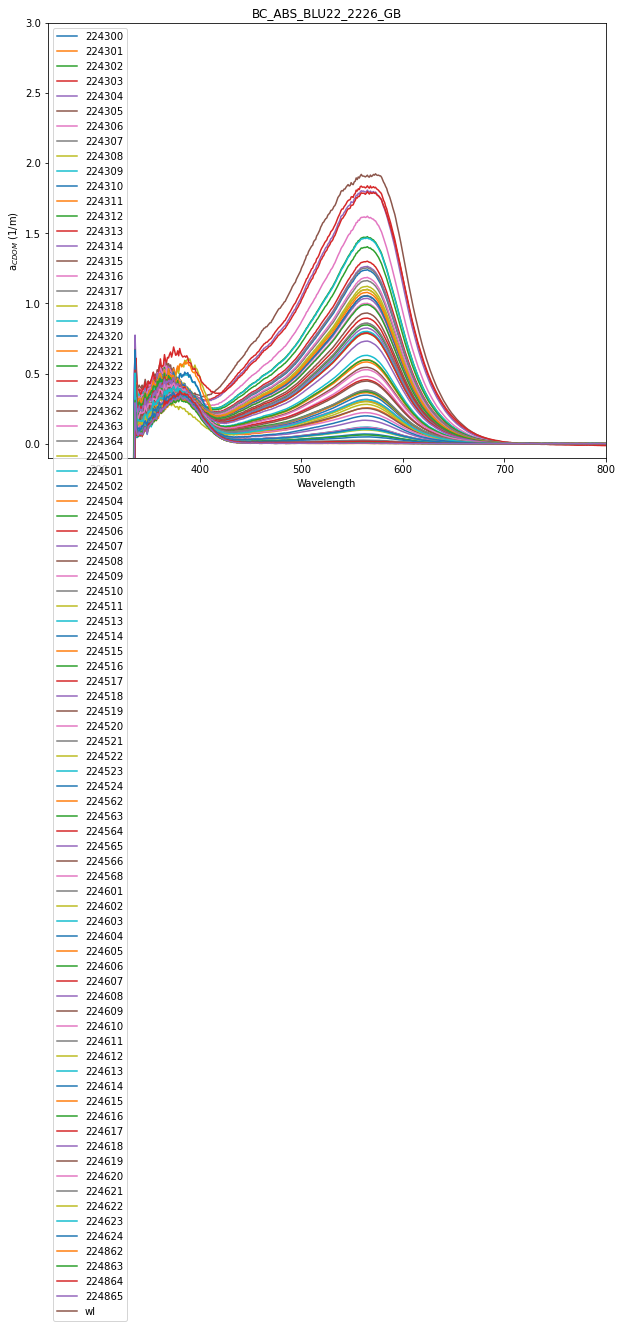

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")


In [7]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs.to_csv(path2)

ss_outs

,abs_562,intagration
sample,,
224300,0.004483,0.521669
224301,0.581269,63.233936
224302,1.470661,167.108432
224303,1.829263,228.088371
224304,1.797105,220.773056
...,...,...
224624,0.197889,21.284118
224862,0.001826,0.301154
224863,0.009394,1.061003


EXPERIMENTAL